# Code 4

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from datasets import load_dataset
import math
import numpy as np

from einops import rearrange # einstein operation

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class InferenceParams(nn.Module):
    def __init__(self):

        self.max_sequence_len = 30
        self.rotary_dim = 3
        self.n_layer = 4
        self.batch_size = 32
        self.n_embd = 20
        self.n_head = 4
        self.vocab_size = 50257
        
config = InferenceParams()

In [3]:
sample = 50

dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token  

subset_dataset = dataset['train'][:sample]['text']

tokenized_dataset = tokenizer(
    subset_dataset,
    return_tensors='pt',
    padding='max_length',  # Pad sequences to the max_seq_length
    truncation=True,  # Truncate sequences if they exceed max_seq_length
    max_length=config.max_sequence_len  # Set the maximum sequence length
)

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
def get_batch(data, batch_size):
    idx = torch.randint(0, len(data), size=(batch_size,))
    
    return data[idx]

data = tokenized_dataset['input_ids']
input_ids = get_batch(data, config.batch_size)
input_ids.shape

torch.Size([32, 30])

In [5]:
class Embedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        
    def forward(self, input_ids):
        input_shape = input_ids.shape[-1]
        input_ids = input_ids.view(-1, input_shape)
        
        hidden_states = self.wte(input_ids)
        
        return hidden_states

m = Embedding(config)
hidden_states = m(input_ids)
hidden_states.shape

torch.Size([32, 30, 20])

In [6]:
class RotaryPositionEmbedding(nn.Module):
    def __init__(self, config, base = 10000):
        super().__init__()
        self.dim = config.rotary_dim 
        
        inv_freq = 1.0 / (base ** (torch.arange(0, self.dim, 2) / self.dim))
        self.register_buffer("inv_freq", inv_freq)
        
        self.cos_cache = None
        self.sin_cache = None
        
    def forward(self, qkv):
        seqlen = qkv.shape[1]
        
        # Update cos sin cache
        t = torch.arange(seqlen)
        freqs = torch.outer(t, self.inv_freq)
        
        self.cos_cache = torch.cos(freqs)
        self.sin_cache = torch.sin(freqs)
        
        # Apply rotary qkv
        rotary_dim = self.cos_cache.shape[1]
        rotary_dim *= 2
        
        q_rot = qkv[:, :, 0, :, :rotary_dim]
        q_pass = qkv[:, :, 0, :, rotary_dim:]
        
        k_rot = qkv[:, :, 1, :, :rotary_dim]
        k_pass = qkv[:, :, 1, :, rotary_dim:]
        
        # Splits the queries and keys in half
        q1, q2 = q_rot.chunk(2, dim=-1)
        k1, k2 = k_rot.chunk(2, dim=-1)
        c, s = rearrange(self.cos_cache, "t d -> t 1 d"), rearrange(self.sin_cache, "t d -> t 1 d")
        
        # Computes the new keys and queries
        q_rot = torch.cat([q1 * c - q2 * s, q1 * s - q2 * c], dim=-1)
        k_rot = torch.cat([k1 * c - k2 * s, k1 * s - k2 * c], dim = -1)
        
        return torch.cat(
            [
                torch.cat([q_rot, q_pass], dim=-1).unsqueeze(2),
                torch.cat([k_rot, k_pass], dim=-1).unsqueeze(2),
                qkv[:, :, 2:3, :, :]
            ],
            dim=2
        )

In [7]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        n_inner = 4 * config.n_embd
        
        self.fc1 = nn.Linear(config.n_embd, n_inner)
        self.fc2 = nn.Linear(n_inner, config.n_embd)
        self.act = nn.ReLU()
        
    def forward(self, hidden_states):
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.fc2(hidden_states)
        
        return hidden_states
    
m = MLP(config)
ffwd_out = m(hidden_states)
ffwd_out.shape

torch.Size([32, 30, 20])

In [8]:
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        pass
            
    def forward(self, qkv):
        seq_len = qkv.shape[1]
        q, k, v = qkv.unbind(2)
        
        softmax_scale = 1.0 / math.sqrt(q.shape[-1])
        scores = torch.einsum("bthd, bshd -> bhts", q, k * softmax_scale)

        casual_mask = torch.triu(torch.full((seq_len, seq_len), -10000), 1)
        scores += casual_mask
        
        attention = torch.softmax(scores, dim=-1)
        
        output = torch.einsum("bhts, bshd -> bthd", attention, v)
        
        return output

In [11]:
class MHA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.rotary_emb = RotaryPositionEmbedding(config)
        
        self.head_dim = config.n_embd // config.n_head
        opt_size = config.n_head * self.head_dim
        hidden_size = config.n_embd
        
        self.Wqkv = nn.Linear(hidden_size, 3 * opt_size)
        self.out_proj = nn.Linear(opt_size, hidden_size)
        
        self.inner_attn = SelfAttention()
        
    def forward(self, x):
        qkv = self.Wqkv(x)
        qkv = rearrange(qkv, 'b t (three h d) -> b t three h d', three=3, d=self.head_dim)
        
        qkv = self.rotary_emb(qkv)
        
        output = self.inner_attn(qkv)
        
        output = rearrange(output, "... h d -> ... (h d)")
        attn_out = self.out_proj(output)
        
        return attn_out
    
m = MHA(config)
attn_out = m(hidden_states)
attn_out.shape

torch.Size([32, 30, 20])

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.ln = nn.LayerNorm(config.n_embd)
        
        self.attn = MHA(config)
        self.ffwd = MLP(config)
        
    def forward(self, hidden_states):
        residual = hidden_states
        hidden_states = self.ln(hidden_states)
        
        attn_out = self.attn(hidden_states)
        ffwd_out = self.ffwd(hidden_states)
        
        output = attn_out + ffwd_out + residual
        return output

m = Block(config)
output = m(hidden_states)
output.shape

torch.Size([32, 30, 20])

In [13]:
class LMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.ln = nn.LayerNorm(config.n_embd)
        self.linear = nn.Linear(config.n_embd, config.vocab_size)
        
    def forward(self, output):
        output = self.ln(output)
        logits = self.linear(output)
        
        return logits
    
m = LMHead(config)
logits = m(output)
logits.shape

torch.Size([32, 30, 50257])

In [48]:
class SequentialForLM_Not(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        modules = [Embedding(config)]
        modules += [Block(config) for _ in range(config.n_layer)]
        modules.append(LMHead(config))
        
        self.layers = nn.Sequential(*modules)
        
    def forward(self, input_ids):
        return self.layers(input_ids)
    
m = SequentialForLM_Not(config)
logits = m(input_ids)
logits.shape

torch.Size([32, 30, 50257])

In [49]:
class LMLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss_fct = nn.CrossEntropyLoss()
        
    def forward(self, logits, labels):
        
        logits = logits[..., :-1, :].contiguous()
        labels = labels[..., 1:].contiguous()          
                             
        loss = self.loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return loss

lm_loss = LMLoss()
loss = lm_loss(logits, input_ids)
loss

tensor(10.9480, grad_fn=<NllLossBackward0>)

In [51]:
for name, param in m.named_parameters():
    if 'weight' in name:
        print(name)

layers.0.wte.weight
layers.1.ln.weight
layers.1.attn.Wqkv.weight
layers.1.attn.out_proj.weight
layers.1.ffwd.fc1.weight
layers.1.ffwd.fc2.weight
layers.2.ln.weight
layers.2.attn.Wqkv.weight
layers.2.attn.out_proj.weight
layers.2.ffwd.fc1.weight
layers.2.ffwd.fc2.weight
layers.3.ln.weight
layers.3.attn.Wqkv.weight
layers.3.attn.out_proj.weight
layers.3.ffwd.fc1.weight
layers.3.ffwd.fc2.weight
layers.4.ln.weight
layers.4.attn.Wqkv.weight
layers.4.attn.out_proj.weight
layers.4.ffwd.fc1.weight
layers.4.ffwd.fc2.weight
layers.5.ln.weight
layers.5.linear.weight


In [52]:
model_not = SequentialForLM_Not(config)

weight_names = {
    "Embedding": 'layers.0.wte.weight',
    "Linear": 'layers.1.attn.Wqkv.weight',
    "Layer Norm": 'layers.1.ln.weight'
}

weight_dict_not = {}
for name, param in model_not.named_parameters():
    param = param.view(-1).detach()
    if name in weight_names.values():
        param_name = [key for key, value in weight_names.items() if value == name][0]
        weight_dict_not[param_name] = param

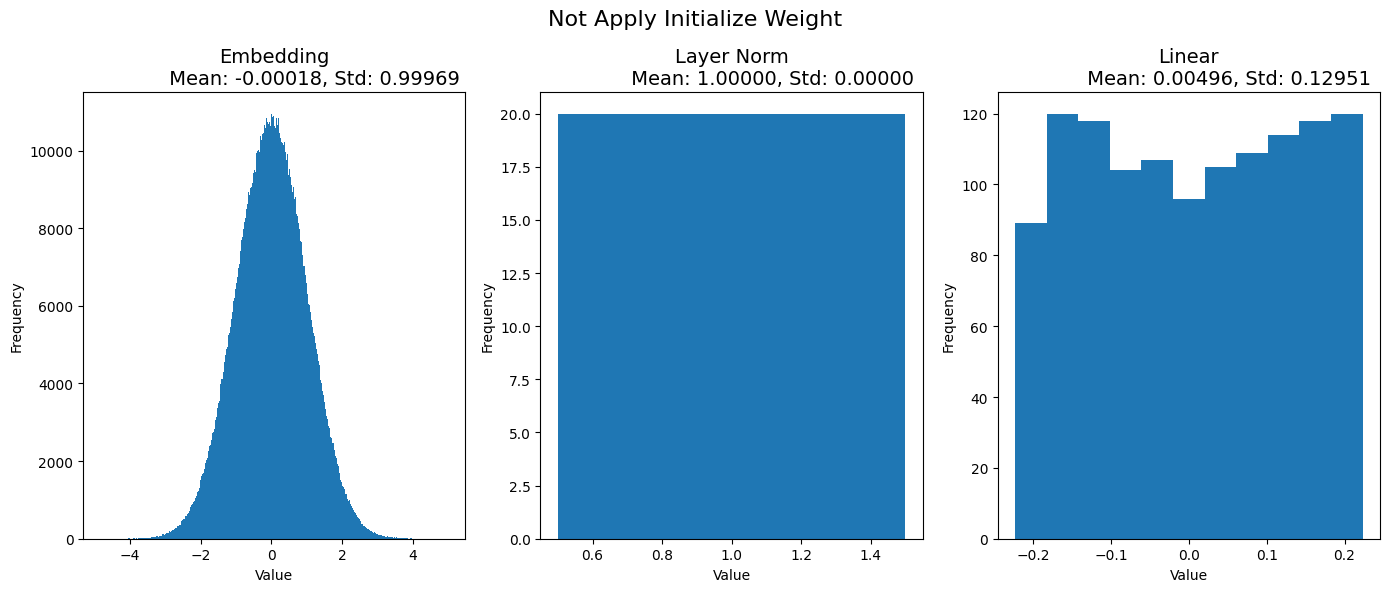

In [53]:
import matplotlib.pyplot as plt

def show_graph_init_weight(weight_dict, string):
    fig, axs = plt.subplots(1, len(weight_dict), figsize=(14, 6))

    for i, (param_name, param_value) in enumerate(weight_dict.items()):
        ax = axs[i]
        ax.hist(param_value, bins='fd')
        
        ax.set_title(f"{param_name}\n \
            Mean: {param_value.mean():.5f}, Std: {param_value.std():.5f}", fontsize=14)
        
        ax.set_xlabel("Value", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)

    fig.suptitle(f"{string} Apply Initialize Weight", fontsize=16)
    plt.tight_layout()
    plt.show()
    
show_graph_init_weight(weight_dict_not, "Not")

In [54]:
class SequentialForLM_Have(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        modules = [Embedding(config)]
        modules += [Block(config) for _ in range(config.n_layer)]
        modules.append(LMHead(config))
        
        self.layers = nn.Sequential(*modules)
        
        self.apply(self._init_weights)
        
        
    def forward(self, input_ids):
        return self.layers(input_ids)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)   

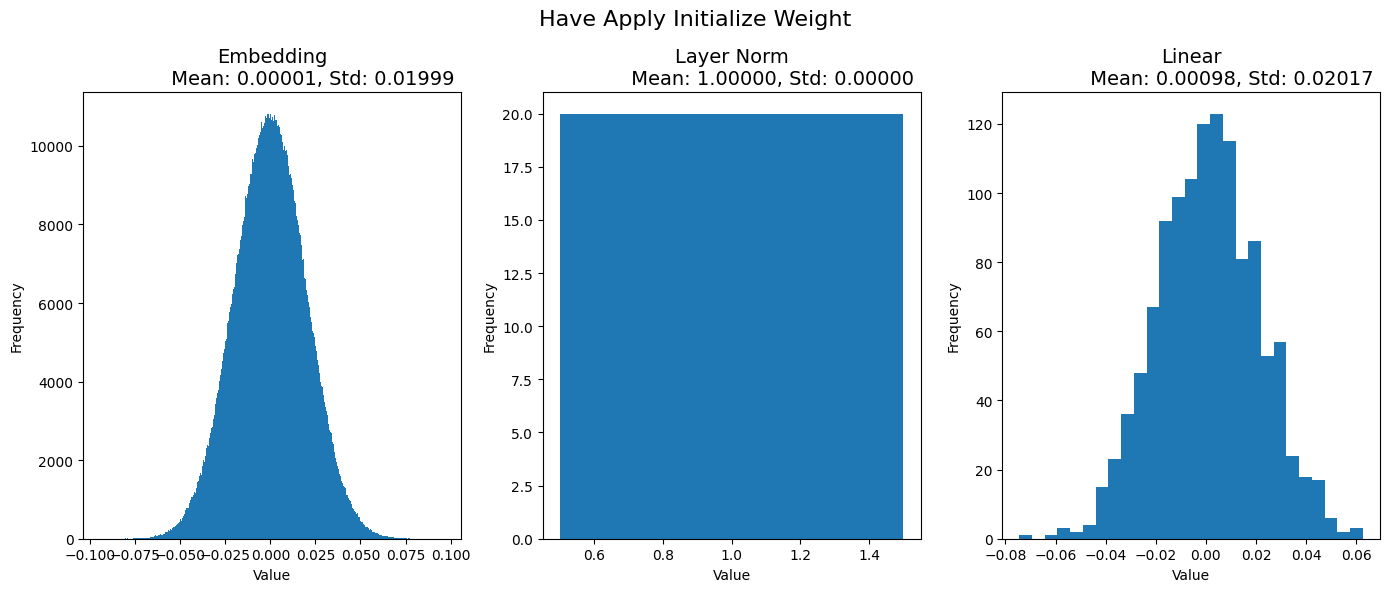

In [55]:
model_have = SequentialForLM_Have(config)

weight_dict_have = {}
for name, param in model_have.named_parameters():
    param = param.view(-1).detach()
    if name in weight_names.values():
        param_name = [key for key, value in weight_names.items() if value == name][0]
        weight_dict_have[param_name] = param
        
show_graph_init_weight(weight_dict_have, "Have")

In [56]:
def get_layers_output(model, input_data):
    layers_output = []
    
    hidden_layers = input_data[0]
    for module in model.layers:
        hidden_layers = module(hidden_layers)
        layers_output.append(hidden_layers.detach().numpy().flatten())

    return layers_output

layers_output_not = get_layers_output(model_not, input_ids)
layers_output_have = get_layers_output(model_have, input_ids)

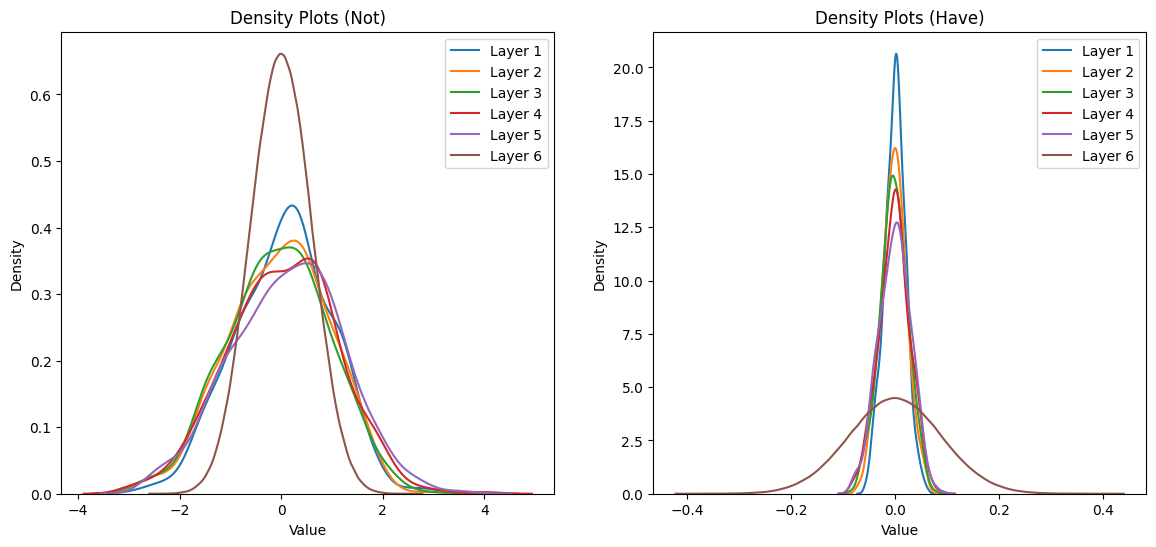

In [57]:
import seaborn as sns

def show_density_plots(layers_output, ax, title):
    for i, layer_output in enumerate(layers_output):
        sns.kdeplot(layer_output, ax=ax, label=f"Layer {i+1}")
        
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_density_plots(layers_output_not, axes[0], "Density Plots (Not)")
show_density_plots(layers_output_have, axes[1], "Density Plots (Have)")

plt.show()

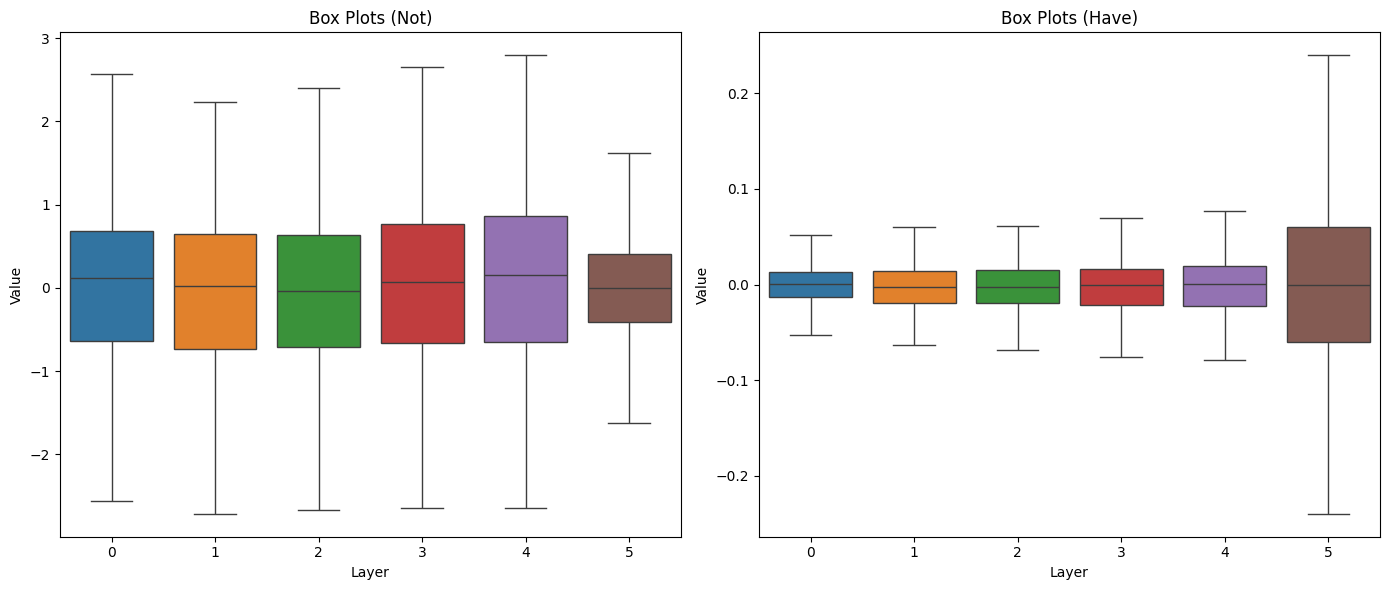

In [58]:
def show_box_plots(layers_output, ax, title):
    sns.boxplot(data=layers_output, ax=ax, showfliers=False)
        
    ax.set_xlabel("Layer")
    ax.set_ylabel("Value")
    ax.set_title(title)
    
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_box_plots(layers_output_not, axes[0], "Box Plots (Not)")
show_box_plots(layers_output_have, axes[1], "Box Plots (Have)")

plt.tight_layout()
plt.show()

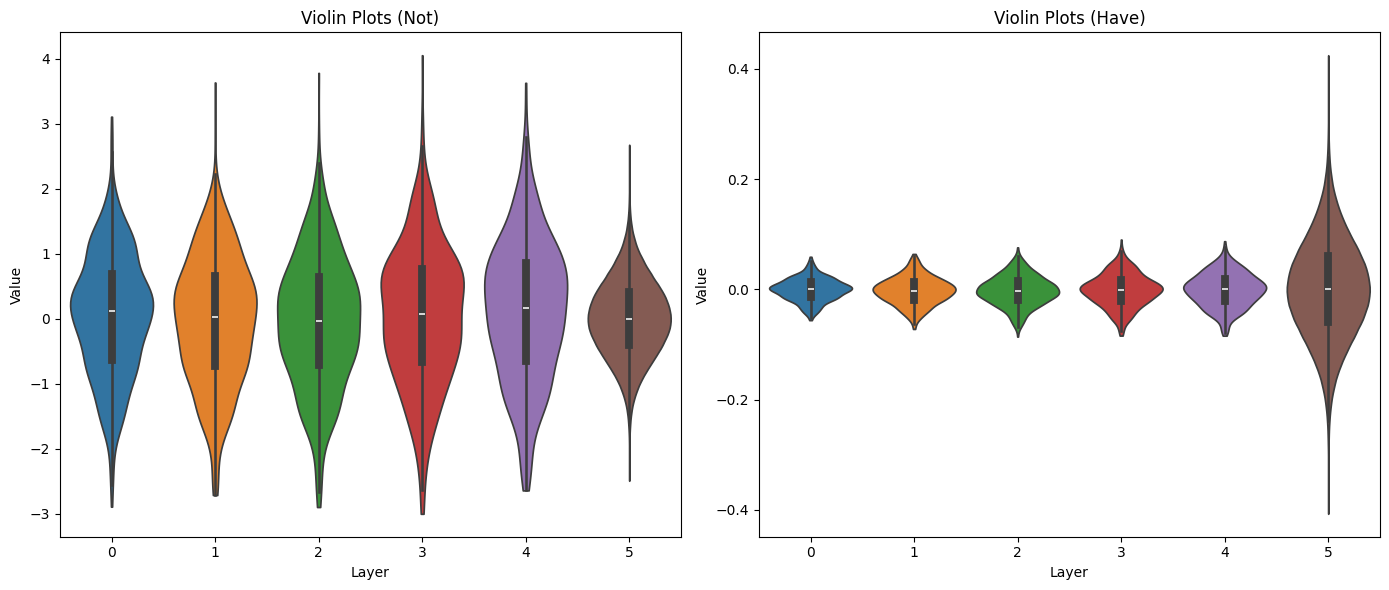

In [60]:
def show_violin_plots(layers_output, ax, title):
    sns.violinplot(data=layers_output, ax=ax, inner='box', cut=0)
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Value")
    ax.set_title(title)        

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_violin_plots(layers_output_not, axes[0], "Violin Plots (Not)")
show_violin_plots(layers_output_have, axes[1], "Violin Plots (Have)")

plt.tight_layout()
plt.show()